Setup

In [141]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torchvision import transforms
from torchvision.utils import save_image
from tqdm import tqdm
%run ConV_VAE.ipynb
%run loader.ipynb
%run test.ipynb
%run train.ipynb

In [142]:
plt.rcParams['figure.dpi'] = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'
####### IMPORTANT ######
# set this flag to true if you want to load the model beforehand
load = False

Additional Setup to use Tensorboard<br>
!pip install -q tensorflow<br>
%load_ext tensorboard

In [143]:
normalize = transforms.Normalize(160, 50)
transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])
train_data = CustomImageDataset('../Data/sign_mnist_train.csv', transform=transform)
test_data = CustomImageDataset('../Data/sign_mnist_test.csv')
# mnist_data = datasets.MNIST('./data',
#              transform=transforms.ToTensor(),
#             download=True)

Put it into a dataloader for easier handling in pytorch

In [144]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True)

In [145]:
model = ConvVarAutoencoder().to(device)
if (load):
    model.load_state_dict(torch.load("model_good_50.pt", map_location=device))

criterion = F.mse_loss
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.1)

In [146]:
epochs = 1
train_losses = []
test_losses = []
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    # Train on data
    train_loss = train_vae(train_loader, model, optimizer, device)
    test_loss = test(epoch, model, test_loader)
    print("Train Loss: ", train_loss.item(), model.encoder.kl.item(), end='\n')
    print('====> Test set loss: {:.4f}'.format(test_loss))
    # Write metrics to Tensorboard
    #writer.add_scalars("Loss", {'Train': train_loss}, epoch)
    if epoch % 10 == 0:
        torch.save(model.state_dict(), "model" + str(epoch) + ".pt")
        with torch.no_grad():
            sample = torch.randn(64, 2048).to(device)
            sample = model.decoder(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       '../results/' + str(epoch) + '.png')
    train_losses.append(train_loss.cpu().detach().numpy())
    test_losses.append(test_loss)

100%|██████████| 1/1 [00:16<00:00, 16.18s/it]

Train Loss:  146601.109375 nan
====> Test set loss: nan


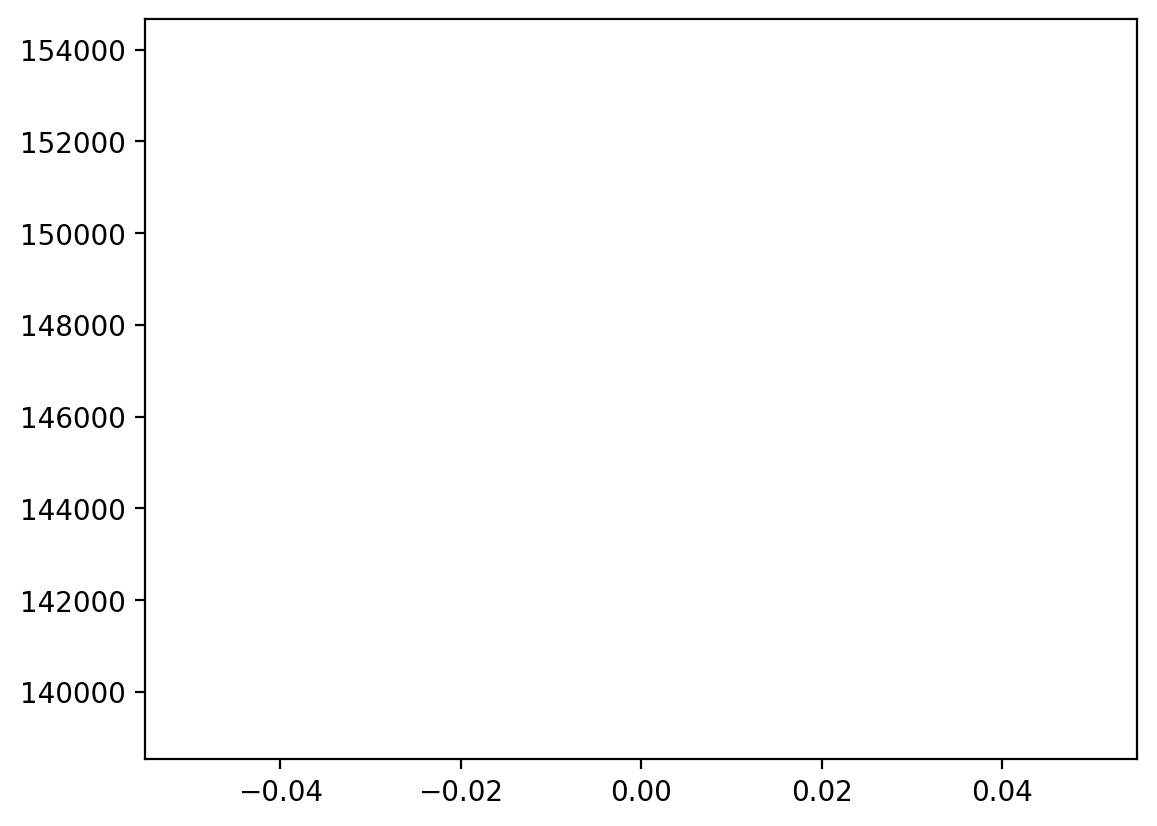

In [147]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()